# 웹 검색 모듈 추가

**절차**

1. Naive RAG 수행
2. 검색된 문서에 대한 관련성 체크(Groundedness Check)
3. (이번 튜토리얼) Web Search 추가

**참고**

- 이전 튜토리얼에서 확장된 내용이므로, 겹치는 부분이 있을 수 있습니다. 부족한 설명은 이전 튜토리얼을 참고해주세요.

![langgraph-web-search](assets/langgraph-web-search.png)

## 환경 설정

In [1]:
# !pip install -U langchain-teddynote

In [2]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [3]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LangGraph-Structures")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LangGraph-Structures


## 기본 PDF 기반 Retrieval Chain 생성

여기서는 PDF 문서를 기반으로 Retrieval Chain 을 생성합니다. 가장 단순한 구조의 Retrieval Chain 입니다.

단, LangGraph 에서는 Retirever 와 Chain 을 따로 생성합니다. 그래야 각 노드별로 세부 처리를 할 수 있습니다.

**참고**

- 이전 튜토리얼에서 다룬 내용이므로, 자세한 설명은 생략합니다.

In [5]:
from rag.pdf import PDFRetrievalChain

# PDF 문서를 로드합니다.
pdf = PDFRetrievalChain(["/Users/Owner/git_inside/langchain-study/data/SPRI_AI_Brief_2023년12월호_F.pdf"]).create_chain()

# retriever와 chain을 생성합니다.
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

## State 정의

`State`: Graph 의 노드와 노드 간 공유하는 상태를 정의합니다.

일반적으로 `TypedDict` 형식을 사용합니다.

이번에는 상태(State)에 관련성(relevance) 체크 결과를 추가합니다.

In [6]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages


# GraphState 상태 정의
class GraphState(TypedDict):
    question: Annotated[str, "Question"]  # 질문
    context: Annotated[str, "Context"]  # 문서의 검색 결과
    answer: Annotated[str, "Answer"]  # 답변
    messages: Annotated[list, add_messages]  # 메시지(누적되는 list)
    relevance: Annotated[str, "Relevance"]  # 관련성

## 노드(Node) 정의

- `Nodes`: 각 단계를 처리하는 노드입니다. 보통은 Python 함수로 구현합니다. 입력과 출력이 상태(State) 값입니다.
  
**참고**  

- `State`를 입력으로 받아 정의된 로직을 수행한 후 업데이트된 `State`를 반환합니다.

In [7]:
from langchain_openai import ChatOpenAI
from langchain_teddynote.evaluator import GroundednessChecker
from langchain_teddynote.messages import messages_to_history
from rag.utils import format_docs


# 문서 검색 노드
def retrieve_document(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    retrieved_docs = pdf_retriever.invoke(latest_question)

    # 검색된 문서를 형식화합니다.(프롬프트 입력으로 넣어주기 위함)
    retrieved_docs = format_docs(retrieved_docs)

    # 검색된 문서를 context 키에 저장합니다.
    return GraphState(context=retrieved_docs)


# 답변 생성 노드
def llm_answer(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 검색된 문서를 상태에서 가져옵니다.
    context = state["context"]

    # 체인을 호출하여 답변을 생성합니다.
    response = pdf_chain.invoke(
        {
            "question": latest_question,
            "context": context,
            "chat_history": messages_to_history(state["messages"]),
        }
    )
    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.
    return GraphState(
        answer=response, messages=[("user", latest_question), ("assistant", response)]
    )


# 관련성 체크 노드
def relevance_check(state: GraphState) -> GraphState:
    # 관련성 평가기를 생성합니다.
    question_answer_relevant = GroundednessChecker(
        llm=ChatOpenAI(model="gpt-4o-mini", temperature=0), target="question-retrieval"
    ).create()

    # 관련성 체크를 실행("yes" or "no")
    response = question_answer_relevant.invoke(
        {"question": state["question"], "context": state["context"]}
    )

    print("==== [RELEVANCE CHECK] ====")
    print(response.score)

    # 참고: 여기서의 관련성 평가기는 각자의 Prompt 를 사용하여 수정할 수 있습니다. 여러분들의 Groundedness Check 를 만들어 사용해 보세요!
    return GraphState(relevance=response.score)


# 관련성 체크하는 함수(router)
def is_relevant(state: GraphState) -> GraphState:
    if state["relevance"] == "yes":
        return "relevant"
    else:
        return "not relevant"

## 검색 노드 추가

이번에는 `TavilySearch` 도구를 사용하여 Web Search 를 수행합니다.

아래는 `TavilySearch` 도구를 사용한 예제입니다.

In [8]:
from langchain_teddynote.tools.tavily import TavilySearch

# 검색 도구 생성
tavily_tool = TavilySearch()

search_query = "2024년 노벨 문학상 수상자는?"

# 다양한 파라미터를 사용한 검색 예제
search_result = tavily_tool.search(
    query=search_query,  # 검색 쿼리
    max_results=3,  # 최대 검색 결과
    format_output=True,  # 결과 포맷팅
)

# 검색 결과 출력
print(search_result)

['<document><title>[속보] 소설가 한강 노벨 문학상 수상..한국 작가 최초 수상 쾌거</title><url>https://www.youtube.com/watch?v=FsMuWl5LYNA</url><content>[속보] 소설가 한강 노벨 문학상 수상..한국 작가 최초 수상 쾌거 - [MBC 뉴스속보] 2024년 10월 10일\\n\\nMBCNEWS\\n18548 likes\\n827138 views\\n11 Oct 2024\\n올해 노벨 문학상 수상자가 우리나라 소설가, 한강 씨로 결정됐습니다.\\n\\n한국 첫 노벨 문학상의 쾌거입니다.\\n\\n한국인이 노벨상을 수상한 것은 지난 2000년 노벨평화상을 탄 고 김대중 전 대통령에 이어 두 번째로 24년 만입니다.\\n\\n노벨 위원회는 \\"역사적 트라우마에 맞서고 인간 삶의 연약함을 드러내는 강렬한 시적 산문\\"을 쓴 작가라고 밝혔습니다.\\n\\n올해 53세인 한 씨는 지난 2016년 소설 \'채식주의자\'로 한국 최초로 노벨문학상과 더불어 3대 문학상으로 꼽히는 인터내셔널 부커상을 한국 최초로 수상했습니다.\\n\\n지난해에는 제주 4·3 사건의 비극을 다룬 장편 소설 \'작별하지 않는다\'로 프랑스 4대 문학상으로 꼽히는 메디치상을 수상한 바 있습니다.\\n\\n노벨상 수상자에게는 상금 1천100만 크로나, 우리돈 약 13억 4천만 원과 메달, 증서가 수여됩니다.\\n\\n#노벨상 #노벨문학상 #한강 #최초 #쾌거 #뉴스 #MBC뉴스 #MBC #뉴스데스크 #뉴스투데이 #뉴스 #라이브 #실시간 \\n\\nⓒ MBC&iMBC 무단 전재, 재배포 및 이용(AI학습 포함)금지\\n248 comments</content><raw># [속보] 소설가 한강 노벨 문학상 수상..한국 작가 최초 수상 쾌거 - [MBC 뉴스속보] 2024년 10월 10일\n\nMBCNEWS\n18548 likes\n827138 views\n11 Oct 2024\n올해 노벨 문학상 수상자가 우리나라 소설가, 한강 씨로

검색 노드로 패키징하여 추가합니다. (함수 생성)

In [10]:
# Web Search 노드
def web_search(state: GraphState) -> GraphState:
    # 검색 도구 생성
    tavily_tool = TavilySearch()

    search_query = state["question"]

    # 다양한 파라미터를 사용한 검색 예제
    search_result = tavily_tool.search(
        query=search_query,  # 검색 쿼리
        topic="general",  # 일반 주제
        max_results=6,  # 최대 검색 결과
        format_output=True,  # 결과 포맷팅
    )

    return {"context": search_result}

## Edges

- `Edges`: 현재 `State`를 기반으로 다음에 실행할 `Node`를 결정하는 Python 함수.

일반 엣지, 조건부 엣지 등이 있습니다.

In [11]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 그래프 정의
workflow = StateGraph(GraphState)

# 노드 추가
workflow.add_node("retrieve", retrieve_document)
workflow.add_node("relevance_check", relevance_check)
workflow.add_node("llm_answer", llm_answer)

# Web Search 노드 추가
workflow.add_node("web_search", web_search)

# 엣지 추가
workflow.add_edge("retrieve", "relevance_check")  # 검색 -> 관련성 체크


# 조건부 엣지를 추가합니다.
workflow.add_conditional_edges(
    "relevance_check",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
    is_relevant,
    {
        "relevant": "llm_answer",  # 관련성이 있으면 답변을 생성합니다.
        "not relevant": "web_search",  # 관련성이 없으면 웹 검색을 수행합니다.
    },
)

workflow.add_edge("web_search", "llm_answer")  # 검색 -> 답변
workflow.add_edge("llm_answer", END)  # 답변 -> 종료

# 그래프 진입점 설정
workflow.set_entry_point("retrieve")

# 체크포인터 설정
memory = MemorySaver()

# 그래프 컴파일
app = workflow.compile(checkpointer=memory)

컴파일한 그래프를 시각화 합니다.

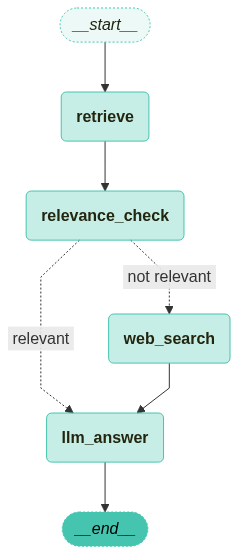

In [12]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

## 그래프 실행

- `config` 파라미터는 그래프 실행 시 필요한 설정 정보를 전달합니다.
- `recursion_limit`: 그래프 실행 시 재귀 최대 횟수를 설정합니다.
- `inputs`: 그래프 실행 시 필요한 입력 정보를 전달합니다.

검색 결과의 `relevance_check` 가 실패할 경우, 검색을 수행하여 웹 검색 결과를 제공합니다.

In [13]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, invoke_graph, random_uuid


# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = GraphState(question="2024년 노벨 문학상 수상자는?")

# 그래프 실행
invoke_graph(app, inputs, config, ["relevance_check", "llm_answer"])

==== [RELEVANCE CHECK] ====
no

🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
relevance:
no

🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
answer:
2024년 노벨 문학상 수상자는 한강 작가입니다. 이는 한국인 최초이자 아시아 여성 최초의 수상입니다.

**Source**
- [2024년 노벨문학상 수상 작가, 한강 - 문학과지성사](https://moonji.com/38049/)
- [2024년 노벨문학상에 한국의 '채식주의자' 작가 한강 수상자 선정 - 노벨사이언스](http://www.nobelscience.net/news/articleView.html?idxno=2189)
- [2024 노벨문학상: 한강 작가 수상! - 교보문고](https://event.kyobobook.co.kr/detail/225983)
('user', '2024년 노벨 문학상 수상자는?')
('assistant', "2024년 노벨 문학상 수상자는 한강 작가입니다. 이는 한국인 최초이자 아시아 여성 최초의 수상입니다.\n\n**Source**\n- [2024년 노벨문학상 수상 작가, 한강 - 문학과지성사](https://moonji.com/38049/)\n- [2024년 노벨문학상에 한국의 '채식주의자' 작가 한강 수상자 선정 - 노벨사이언스](http://www.nobelscience.net/news/articleView.html?idxno=2189)\n- [2024 노벨문학상: 한강 작가 수상! - 교보문고](https://event.kyobobook.co.kr/detail/225983)")


In [14]:
# 그래프 스트리밍 출력
stream_graph(app, inputs, config, ["relevance_check", "llm_answer"])


🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{"score":"no==== [RELEVANCE CHECK] ===="}
no

🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
2024년 노벨 문학상 수상자는 한강 작가입니다. 이는 한국인 최초이자 아시아 여성 최초의 수상입니다.

**Source**
- [2024년 노벨문학상 수상 작가, 한강 - 문학과지성사](https://moonji.com/38049/)
- [2024년 노벨문학상에 한국의 '채식주의자' 작가 한강 수상자 선정 - 노벨사이언스](http://www.nobelscience.net/news/articleView.html?idxno=2189)
- [2024 노벨문학상: 한강 작가 수상! - 교보문고](https://event.kyobobook.co.kr/detail/225983)

In [15]:
# 최종 출력 확인
outputs = app.get_state(config).values

print(f'Question: {outputs["question"]}')
print("===" * 20)
print(f'Answer:\n{outputs["answer"]}')

Question: 2024년 노벨 문학상 수상자는?
Answer:
2024년 노벨 문학상 수상자는 한강 작가입니다. 이는 한국인 최초이자 아시아 여성 최초의 수상입니다.

**Source**
- [2024년 노벨문학상 수상 작가, 한강 - 문학과지성사](https://moonji.com/38049/)
- [2024년 노벨문학상에 한국의 '채식주의자' 작가 한강 수상자 선정 - 노벨사이언스](http://www.nobelscience.net/news/articleView.html?idxno=2189)
- [2024 노벨문학상: 한강 작가 수상! - 교보문고](https://event.kyobobook.co.kr/detail/225983)
